<a href="https://colab.research.google.com/github/WafaSanaa/Computer_Vision/blob/main/D%C3%A9tection_Pneumonie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

paultimothymooney_chest_xray_pneumonia_path = kagglehub.dataset_download('paultimothymooney/chest-xray-pneumonia')
sannaa95_pneumonie_path = kagglehub.dataset_download('sannaa95/pneumonie')

print('Data source import complete.')


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1947_bacteria_4876.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4875.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1952_bacteria_4883.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1954_bacteria_4886.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1951_bacteria_4882.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1949_bacteria_4880.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/per

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # 0 = all logs, 3 = only fatal

In [ ]:
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

E0000 00:00:1748736690.134726      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748736690.208006      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
# dataset paths
train_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train'
test_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/test'
valid_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val'

# define standard parameter values
batch_size = 16
img_height = 224
img_width = 224


# Définir les chemins
data_dir = 'chest_xray'  # dossier racine après extraction
img_size = 224

# Fonction de prétraitement
def preprocess_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Niveaux de gris
    img = cv2.resize(img, (img_size, img_size))       # Redimensionnement
    img = img / 255.0                                 # Normalisation
    return img

# rescaling for validation and test images (no augmentation)
train_data_gen = ImageDataGenerator(rescale=1./255)
test_data_gen = ImageDataGenerator(rescale=1./255)

In [ ]:
# load and preprocess training images with augmentation
train = image_gen.flow_from_directory(
    train_path,
    target_size=(img_height, img_width),
    color_mode='grayscale',
    class_mode='binary',
    batch_size=batch_size
)

# load and preprocess test images (no augmentation, no shuffle)
test = test_data_gen.flow_from_directory(
    test_path,
    target_size=(img_height, img_width),
    color_mode='grayscale',
    shuffle=False,
    class_mode='binary',
    batch_size=batch_size
)

# load and preprocess validation images (no augmentation)
valid = test_data_gen.flow_from_directory(
    valid_path,
    target_size=(img_height, img_width),
    color_mode='grayscale',
    class_mode='binary',
    batch_size=batch_size
)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


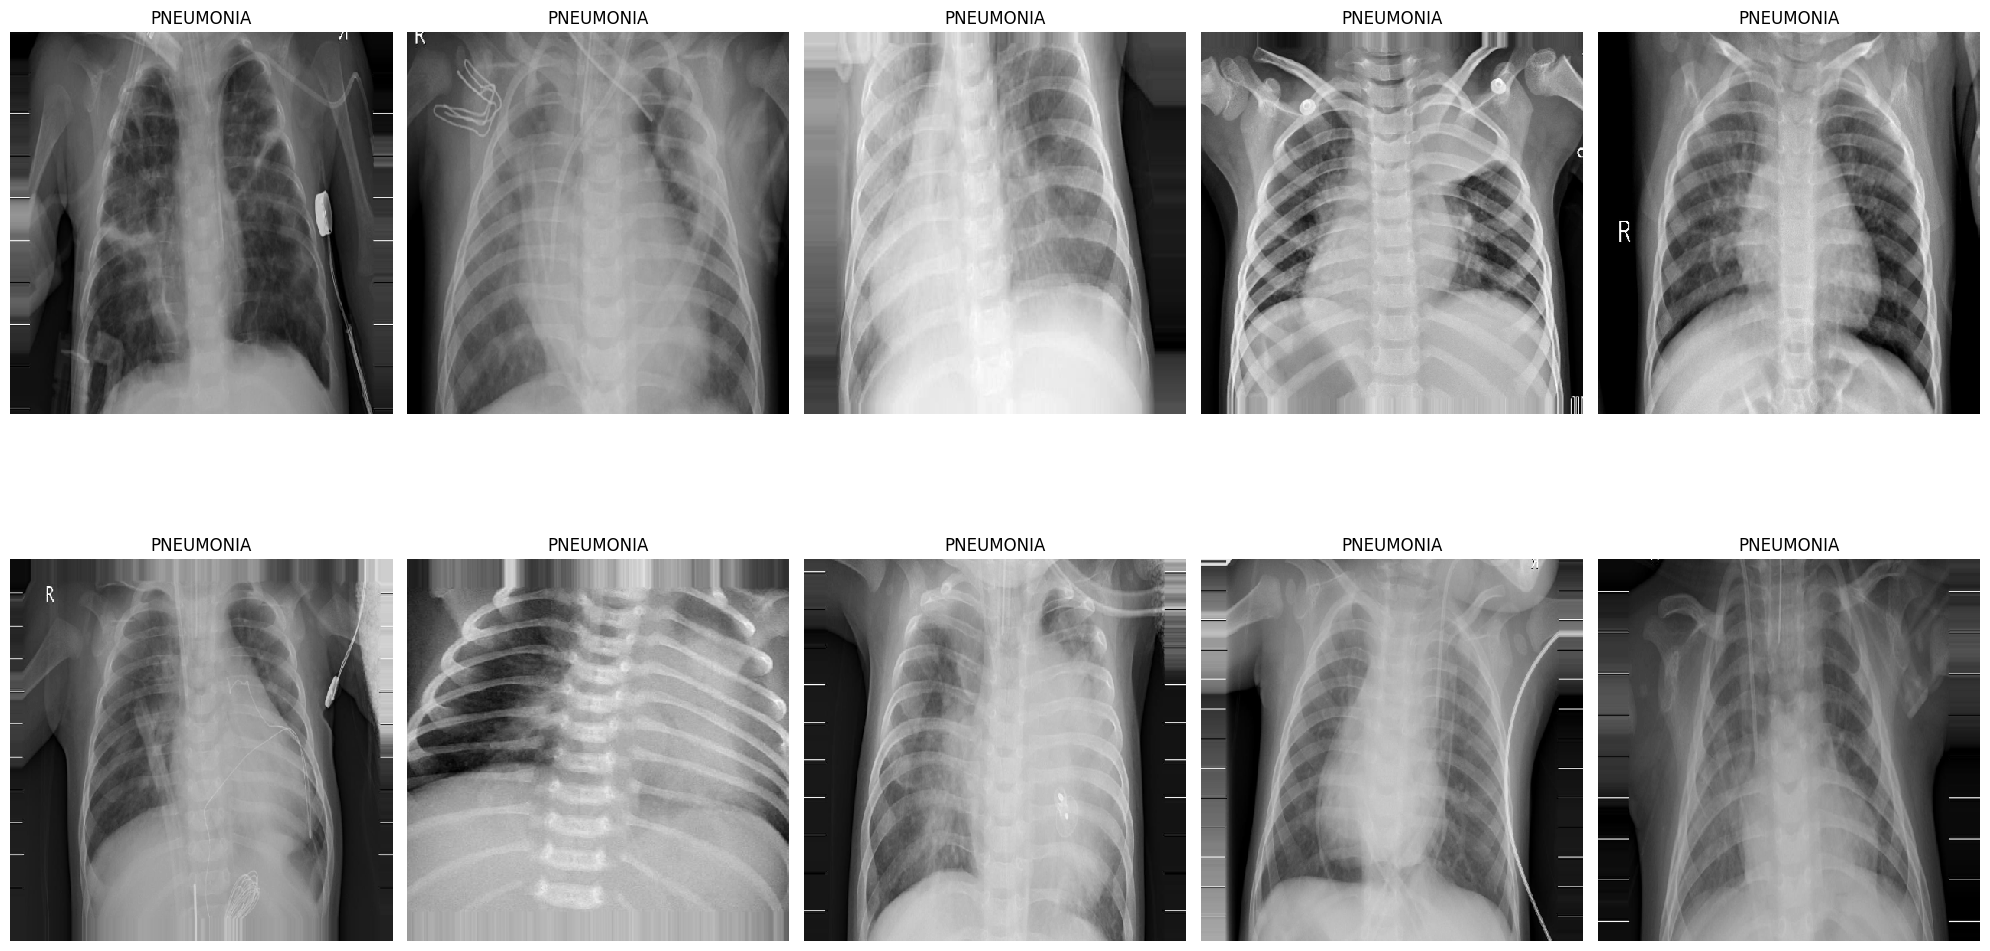

In [ ]:
# display sample images from the training set with labels

plt.figure(figsize=(20, 12))  # define the overall figure size

for i in range(0, 10):
    plt.subplot(2, 5, i+1)  # create a 2x5 grid of subplots

    for X_batch, Y_batch in train:  # fetch one batch from the generator
        image = X_batch[0]          # get the first image in the batch
        label = Y_batch[0]          # get the corresponding label
        label_dict = {0: 'NORMAL', 1: 'PNEUMONIA'}

        plt.title(label_dict.get(label))  # set class name as title
        plt.axis('off')                   # remove axis ticks
        plt.imshow(np.squeeze(image), cmap='gray', interpolation='nearest')  # display grayscale image
        break  # display only one image per iteration

plt.tight_layout()
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
# Construire le modèle CNN
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(224,224,1)),
    layers.MaxPooling2D(2,2),
    layers.Dropout(0.2),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Dropout(0.3),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Dropout(0.4),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entraîner
history = model.fit(train, epochs=10, validation_data=test)


Epoch 1/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 321s 975ms/step - accuracy: 0.7762 - loss: 0.5111 - val_accuracy: 0.8221 - val_loss: 0.4620
Epoch 2/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 320s 980ms/step - accuracy: 0.8970 - loss: 0.2554 - val_accuracy: 0.7500 - val_loss: 0.5546
Epoch 3/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 315s 967ms/step - accuracy: 0.9144 - loss: 0.2131 - val_accuracy: 0.7628 - val_loss: 0.6390
Epoch 4/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 314s 961ms/step - accuracy: 0.9317 - loss: 0.1836 - val_accuracy: 0.7933 - val_loss: 0.4824
Epoch 5/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 313s 960ms/step - accuracy: 0.9332 - loss: 0.1694 - val_accuracy: 0.8606 - val_loss: 0.4611
Epoch 6/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 322s 988ms/step - accuracy: 0.9393 - loss: 0.1607 - val_accuracy: 0.9038 - val_loss: 0.2970
Epoch 7/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 313s 960ms/step - accuracy: 0.9392 - loss: 0.1560 - val_accuracy: 0.8654 - val_loss: 0.3786
Epoch 8/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 322s 986ms/step - accuracy: 0.9327 -

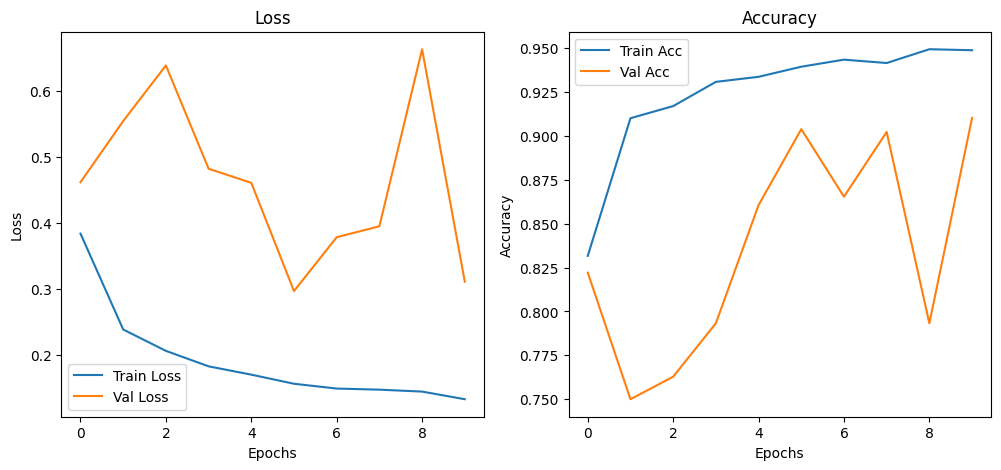

In [ ]:
# Graphiques Loss/Accuracy
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(), plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(), plt.title('Accuracy')
plt.show()

39/39 ━━━━━━━━━━━━━━━━━━━━ 11s 282ms/step


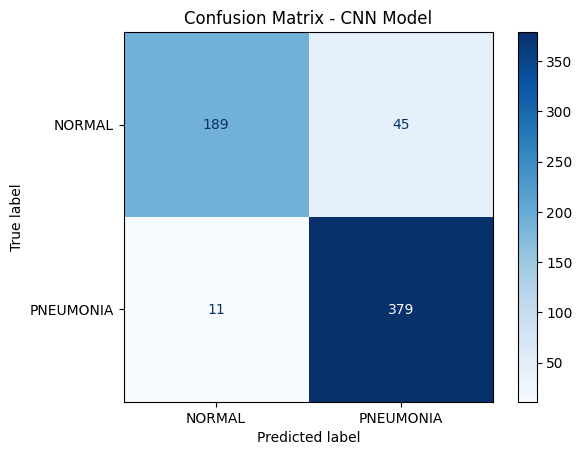

In [ ]:
# Matrice de confusion
y_pred = model.predict(test)
y_pred_classes = (y_pred > 0.5).astype("int32")
cm = confusion_matrix(test.classes, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test.class_indices)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - CNN Model")
plt.show()

In [ ]:
image_path ='/kaggle/input/pneumonie/X-ray.jfif'

In [ ]:
def preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)       # gris
    img = cv2.resize(img, (224, 224))                        # redimensionner
    img = img / 255.0                                        # normaliser
    img = img.reshape(1, 224, 224, 1)                         # adapter la forme pour le modèle
    return img

In [ ]:
def predict_and_display(image_path):
    img = preprocess_image(image_path)
    prediction = model.predict(img)[0][0]  # Prédiction entre 0 et 1

    label = "Pneumonia" if prediction > 0.5 else "Normal"

    plt.imshow(img[0].squeeze(), cmap='gray')
    plt.title(f"Predicted: {label} ({prediction:.2f})")
    plt.axis('off')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


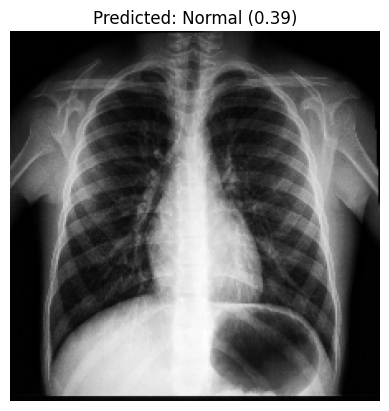

In [ ]:
predict_and_display('/kaggle/input/pneumonie/X-ray.jfif')